In [1]:
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
import numpy as np
import pandas as pd


PROJECT_ROOT = Path.cwd().parent
EMB_DIR = PROJECT_ROOT / "models" / "embeddings"

X = np.load(EMB_DIR / "job_embeddings.npy")
meta = pd.read_parquet(EMB_DIR / "job_embeddings_meta.parquet")

X.shape, meta.shape

((123700, 384), (123700, 3))

In [2]:
import numpy as np

# take a random subset for speed
rng = np.random.default_rng(42)
idx = rng.choice(len(X), size=20000, replace=False)
X_sub = X[idx]

In [3]:
from sklearn.cluster import KMeans

Ks = list(range(20, 51, 5))
inertias = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=5, random_state=42)
    km.fit(X_sub)
    inertias.append(km.inertia_)

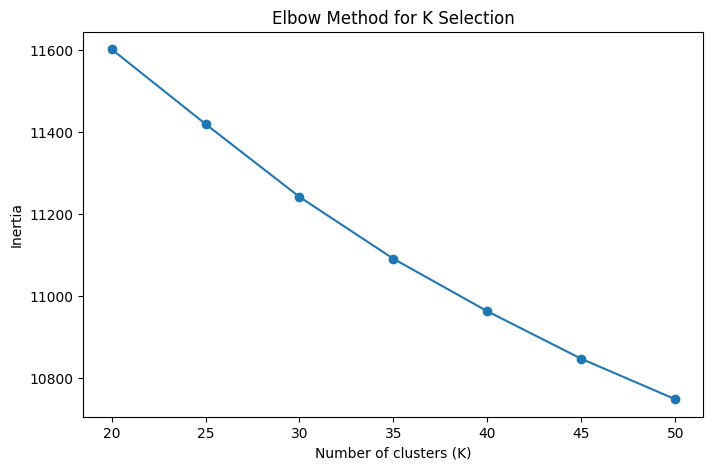

Saved: /Users/teodoro.bevilacqua/Desktop/Job Market Signal Monitor/docs/img/elbow_plot.png


In [5]:
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent  # notebook is in /notebooks
IMG_DIR = PROJECT_ROOT / "docs" / "img"
IMG_DIR.mkdir(parents=True, exist_ok=True)

out_path = IMG_DIR / "elbow_plot.png"

plt.figure(figsize=(8, 5))
plt.plot(Ks, inertias, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K Selection")

plt.savefig(
    out_path,
    dpi=200,
    bbox_inches="tight"
)

plt.show()

print("Saved:", out_path)

Based on the elbow method computed on a random subset of embeddings, K=30 provides a good trade-off between cluster granularity and compactness.

In [ ]:
from sklearn.cluster import KMeans

K = 30  # adjust only if your elbow clearly suggests another value

kmeans = KMeans(
    n_clusters=K,
    n_init=5,
    random_state=42
)

labels = kmeans.fit_predict(X)

In [ ]:
meta = meta.copy()
meta["cluster"] = labels

meta["cluster"].value_counts().head(10)

In [ ]:
meta["cluster"].value_counts().describe()

In [ ]:
top_titles_per_cluster = (
    meta.groupby("cluster")["title"]
    .apply(lambda s: s.value_counts().head(5))
)

top_titles_per_cluster.head()

In [ ]:
cluster_labels = (
    top_titles_per_cluster
    .groupby(level=0)
    .apply(lambda s: " | ".join(s.index.get_level_values(1)[:2]))
)

cluster_labels.head()

In [ ]:
meta["cluster_label"] = meta["cluster"].map(cluster_labels)

meta[["cluster", "cluster_label"]].drop_duplicates().sort_values("cluster").head(10)

In [ ]:
OUT_DIR = PROJECT_ROOT / "models" / "clusters"
OUT_DIR.mkdir(parents=True, exist_ok=True)

meta.to_parquet(OUT_DIR / "job_postings_with_clusters.parquet", index=False)

In [ ]:
if "period" in meta.columns:
    cluster_share = (
        meta.groupby(["period", "cluster"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    cluster_share.head()

In [ ]:
if "period" in meta.columns:
    pivot = cluster_share.pivot(
        index="cluster", columns="period", values="share"
    ).fillna(0)

    pivot["delta"] = pivot.get("late_period", 0) - pivot.get("early_period", 0)
    pivot.sort_values("delta", ascending=False).head(10)

In [ ]:
cluster_sizes = meta["cluster"].value_counts().sort_index()

top_titles = (
    meta.groupby("cluster")["title"]
    .apply(lambda s: s.value_counts().head(8).index.tolist())
)

summary = pd.DataFrame({
    "size": cluster_sizes,
    "top_titles": top_titles
}).sort_values("size", ascending=False)

summary.head(10)

In [ ]:
summary.head(30)

In [ ]:
import pandas as pd

cluster_summary = (
    meta
    .groupby("cluster")
    .agg(
        size=("cluster", "size"),
        top_titles=("title", lambda s: s.value_counts().head(5).index.tolist())
    )
    .sort_values("size", ascending=False)
)

cluster_summary.head(10)

In [ ]:
cluster_summary["cluster_name"] = cluster_summary["top_titles"].apply(
    lambda lst: " | ".join(lst[:2])
)

cluster_summary[["size", "cluster_name"]].head(10)

In [ ]:
if "period" in meta.columns:
    period_share = (
        meta.groupby(["cluster", "period"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    period_pivot = period_share.pivot(
        index="cluster", columns="period", values="share"
    ).fillna(0)

    cluster_summary = cluster_summary.join(period_pivot)

cluster_summary.head(10)

In [ ]:
c = 1  # change this
cols = ["title", "location", "date"]
if "period" in meta.columns:
    cols.append("period")

meta.loc[meta["cluster"] == c, cols].head(15)

In [ ]:
c = 25  # change this
cols = ["title", "location", "date"]
if "period" in meta.columns:
    cols.append("period")

meta.loc[meta["cluster"] == c, cols].head(15)

In [ ]:
# Manual, human-readable cluster labels
cluster_label_map = {
    # meaningful cluster
    25: "Engineering Roles (Electrical & Mechanical)",

    # unclear but accepted cluster
    1: "Clinical Support & Medical Assistant Roles"
}

In [ ]:
meta = meta.copy()

meta["cluster_label_manual"] = meta["cluster"].map(cluster_label_map)

# Fallback to automatic label if no manual label exists
meta["cluster_label_final"] = meta["cluster_label_manual"].fillna(meta["cluster_label"])

In [ ]:
meta[meta["cluster_label_manual"].notna()][
    ["cluster", "cluster_label", "cluster_label_final"]
].drop_duplicates()

In [ ]:
OUT_DIR = PROJECT_ROOT / "models" / "clusters"
OUT_DIR.mkdir(parents=True, exist_ok=True)

meta.to_parquet(
    OUT_DIR / "job_postings_with_clusters.parquet",
    index=False
)

print("Saved clustered data with manual labels.")

Some clusters exhibit strong semantic coherence and map cleanly to well-defined job families (e.g. Engineering Roles – Electrical & Mechanical).
Other clusters aggregate adjacent roles with overlapping terminology and responsibilities, such as Patient Care Technician and Medical Assistant.
Rather than forcing artificial separation, these clusters are retained and explicitly labeled to reflect real-world job market ambiguity.
This approach prioritizes interpretability and realism over overly granular partitioning.

In [ ]:
meta.loc[
    meta["cluster"].isin(cluster_label_map.keys()),
    ["cluster", "cluster_label", "cluster_label_final"]
].drop_duplicates()

In [ ]:
cluster_stats = (
    meta
    .groupby("cluster_label_final")
    .agg(
        size=("cluster", "size")
    )
    .sort_values("size", ascending=False)
)

cluster_stats.head(10)

In [ ]:
if "period" in meta.columns:
    cluster_period = (
        meta
        .groupby(["cluster_label_final", "period"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    cluster_period.head()

In [ ]:
if "period" in meta.columns:
    cluster_period = (
        meta
        .groupby(["cluster_label_final", "period"])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("share")
        .reset_index()
    )

    pivot = cluster_period.pivot(
        index="cluster_label_final",
        columns="period",
        values="share"
    ).fillna(0)

    pivot["delta_share"] = (
        pivot.get("late_period", 0) - pivot.get("early_period", 0)
    )

    pivot = pivot.sort_values("delta_share", ascending=False)

In [ ]:
meta.columns.tolist()

In [ ]:
import pandas as pd

# Ensure date is datetime
meta = meta.copy()
meta["date"] = pd.to_datetime(meta["date"], errors="coerce")

# Drop rows without a valid date (rare but possible)
meta = meta.dropna(subset=["date"])

# Split by midpoint date
split_date = meta["date"].min() + (meta["date"].max() - meta["date"].min()) / 2
meta["period"] = meta["date"].apply(lambda d: "early_period" if d <= split_date else "late_period")

print("Split date:", split_date)
meta["period"].value_counts()

In [ ]:
# cluster share within each period (normalized)
cluster_period = (
    meta.groupby("period")["cluster_label_final"]
    .value_counts(normalize=True)
    .rename("share")
    .reset_index()
)

cluster_period.head()

In [ ]:
pivot = (
    cluster_period
    .pivot(index="cluster_label_final", columns="period", values="share")
    .fillna(0)
)

pivot["delta_share"] = pivot["late_period"] - pivot["early_period"]
pivot = pivot.sort_values("delta_share", ascending=False)

pivot.head(10)

In [ ]:
top_rising = pivot.head(5)
top_declining = pivot.tail(5)

top_rising, top_declining

In [ ]:
cluster_period.columns.tolist()

Over the observed two-month window, cluster share shifted noticeably across job families. Software engineering roles increased the most in relative share (+2.02pp), followed by electrical/mechanical engineering (+0.99pp), project management (+0.90pp), and network/technical support (+0.84pp). Commercial roles also showed a modest rise, with outside sales increasing by +0.76pp. On the declining side, healthcare support clusters dropped sharply, with RN/CNA-related postings decreasing by −4.32pp and RN/LTAC–NP roles by −2.97pp. Several retail and business development clusters also decreased by around one percentage point. Given the short time horizon, these movements should be interpreted as short-window shifts in posting composition rather than long-term labor market trends, but they demonstrate how semantic clustering enables interpretable monitoring at the job-family level.

In [ ]:
for label in list(top_rising.index[:2]) + list(top_declining.index[:2]):
    print("\nCLUSTER:", label)
    print(meta.loc[meta["cluster_label_final"] == label, "title"].value_counts().head(10))

In [ ]:
signal_table = (
    pivot
    .reset_index()
    .rename(columns={"cluster_label_final": "Job Family"})
)

signal_table

In [ ]:
signal_summary = pd.concat([
    signal_table.head(5).assign(signal="Rising"),
    signal_table.tail(5).assign(signal="Declining")
])

signal_summary

In [ ]:
DOCS_DIR = PROJECT_ROOT / "docs"
DOCS_DIR.mkdir(exist_ok=True)

signal_summary_rounded.to_csv(
    DOCS_DIR / "top_rising_declining_clusters.csv",
    index=False
)

In [ ]:
(DOCS_DIR / "top_rising_declining_clusters.csv").exists()

In [ ]:
import pandas as pd

plot_df = (
    pivot[["delta_share"]]
    .reset_index()
    .rename(columns={"cluster_label_final": "Job Family"})
)

plot_df.head()

In [ ]:
import matplotlib.pyplot as plt

TOP_N = 10

top_rise = plot_df.nlargest(TOP_N, "delta_share")
top_fall = plot_df.nsmallest(TOP_N, "delta_share")
plot_top = pd.concat([top_rise, top_fall], axis=0)

plt.figure(figsize=(10, 6))
plt.barh(plot_top["Job Family"], plot_top["delta_share"])
plt.axvline(0)
plt.title(f"Job Family Share Change (Late − Early): Top {TOP_N} Rising & Declining")
plt.xlabel("Δ share")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
out_path = IMG_DIR / "delta_share_top_movers.png"
plt.figure(figsize=(10, 6))
plt.barh(plot_top["Job Family"], plot_top["delta_share"])
plt.axvline(0)
plt.title(f"Job Family Share Change (Late − Early): Top {TOP_N} Rising & Declining")
plt.xlabel("Δ share")
plt.ylabel("")
plt.tight_layout()
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path)